# data format
each training sample is going to be:
1 RGB image
16 joints coordinate of 2d

In [65]:
import os
import sys

import pandas as pd
import torch
from sklearn.model_selection import KFold
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader


class HandJointsPngAndCsvDataset(Dataset):
    def __init__(self, image_dir, joint_dir, image_size=(512, 512)):
        self.image_dir = image_dir
        self.joint_dir = joint_dir
        self.image_size = image_size
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_file = image_file.replace(".png", "_joints2d.csv")
        label_path = os.path.join(self.joint_dir, label_file)

        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)

        joint_df = pd.read_csv(label_path)
        coords = joint_df[['u', 'v']].values.astype(np.float32)
        coords /= self.image_size[0]

        return img, torch.tensor(coords)


# load the data

In [66]:
image_dir = '../../../scripts/auto_generator/ply2obj2img'
label_dir = '../../../scripts/auto_generator/ply2obj2img'

dataset = HandJointsPngAndCsvDataset(image_dir, label_dir)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

img, joints = dataset[0]
print(img.shape)
print(joints.shape)

torch.Size([3, 512, 512])
torch.Size([16, 2])


# define the model

In [67]:
class MyHandEstimator(nn.Module):
    def __init__(self, num_joints=16):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2),  # output 128*128
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  # output 64*64
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # output 32*32
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(128, num_joints * 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x.view(-1, 16, 2)


# compute the pixel error

In [68]:
import numpy as np


def compute_pixel_error(pred, gt, image_size=512):
    """
    Compute mean pixel error between predicted and ground-truth joint positions.

    Args:
        pred (np.ndarray): shape (16, 2), normalized predicted coordinates (0~1)
        gt (np.ndarray): shape (16, 2), normalized ground truth (0~1)
        image_size (int): width/height in pixels

    Returns:
        float: average Euclidean distance in pixels
    """
    pred_px = pred * image_size
    gt_px = gt * image_size

    pixel_distances = np.linalg.norm(pred_px - gt_px, axis=1)
    return np.mean(pixel_distances), pixel_distances

# define hyperparameters

In [69]:
hyperparameters = [
    {'lr': 1e-4, 'batch_size': 16},
    {'lr': 5e-5, 'batch_size': 16},
    {'lr': 1e-6, 'batch_size': 32},
]

# dataset loading and k-fold cross validation setup

In [70]:
K_outer = 5
outer_cv = KFold(n_splits=K_outer, shuffle=True, random_state=42)

outer_results = []

In [71]:
def evaluate(model, loader):
    model.eval()
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)
            total += loss.item() * images.size(0)
    return total / len(loader.dataset)

In [72]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = []
for outer_fold, (train_and_val_idx, test_idx) in enumerate(outer_cv.split(dataset)):
    train_and_val_set = Subset(dataset, train_and_val_idx)
    test_set = Subset(dataset, test_idx)

    # Inner k fold
    K_inner = 5
    inner_cv = KFold(n_splits=K_inner, shuffle=True, random_state=42)

    maxi_score = sys.maxsize
    best_params = None

    for params in hyperparameters:
        val_loss = []
        print(f'params: {params}, training started -------------------------------------------------------')

        for inner_train_idx, inner_val_idx in inner_cv.split(train_and_val_idx):
            inner_train_set = Subset(dataset, np.array(train_and_val_idx)[inner_train_idx])
            inner_val_set = Subset(dataset, np.array(train_and_val_idx)[inner_val_idx])

            train_loader = torch.utils.data.DataLoader(inner_train_set, batch_size=params['batch_size'], shuffle=True)
            val_loader = torch.utils.data.DataLoader(inner_val_set, batch_size=params['batch_size'], shuffle=True)

            model = MyHandEstimator(num_joints=16).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
            criterion = nn.L1Loss()

            epochs_count = 30
            for epoch in range(epochs_count):
                print(f'epoch: {epoch}')
                model.train()
                total_loss = 0
                for img, joints in train_loader:
                    img, joints = img.to(device), joints.to(device)
                    optimizer.zero_grad()
                    preds = model(img)
                    loss = criterion(preds, joints)
                    total_loss += loss.item() * img.size(0)
                    loss.backward()
                    optimizer.step()
                print(f'total loss: {total_loss / len(train_loader)}')

            # evaluation
            ev = evaluate(model, val_loader)
            val_loss.append(ev)
            print(f'loss: {ev}')
        avg_val_loss = np.mean(val_loss)
        print(f'params {params} loss is:{avg_val_loss}')

        if avg_val_loss < maxi_score:
            best_params = params
            maxi_score = avg_val_loss
    print(f"Best Params: {best_params}")

    # retrian using the best hyperparameters
    train_loader = DataLoader(train_and_val_set, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_set, batch_size=best_params['batch_size'], shuffle=False)

    model = MyHandEstimator(num_joints=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

    # Retrain on full train+val
    for epoch in range(15):
        model.train()
        total_loss = 0
        for imgs, joints in train_loader:
            imgs, joints = imgs.to(device), joints.to(device)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = criterion(preds, joints)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'loss: {total_loss / len(train_loader)}')

    # Evaluate on test fold
    test_loss = evaluate(model, test_loader)
    print(f"Outer Fold {outer_fold + 1} Test Loss: {test_loss:.4f}")
    outer_results.append(test_loss)

    models.append(model)

params: {'lr': 0.0001, 'batch_size': 16}, training started -------------------------------------------------------
epoch: 0
total loss: 5.692756354335755
epoch: 1
total loss: 1.3142802736588888
epoch: 2
total loss: 1.0088683953360906
epoch: 3
total loss: 0.9581376281049516
epoch: 4
total loss: 0.9351681125542474
epoch: 5
total loss: 0.9386003055269756
epoch: 6
total loss: 0.9336477832661735
epoch: 7
total loss: 0.9196316226134225
epoch: 8
total loss: 0.9230274921135296
epoch: 9
total loss: 0.9202725733556445
epoch: 10
total loss: 0.9163336895761036
epoch: 11
total loss: 0.9274640434554645
epoch: 12
total loss: 0.9204651611664939
epoch: 13
total loss: 0.9245306422549581
epoch: 14
total loss: 0.9220396554659284
epoch: 15
total loss: 0.9174865691198243
epoch: 16
total loss: 0.9251984043253793
epoch: 17
total loss: 0.9170218663556235
epoch: 18
total loss: 0.9191416904093728
epoch: 19
total loss: 0.9419676086732319
epoch: 20
total loss: 0.933356725270786
epoch: 21
total loss: 0.925698976431

# visualize predicted vs label

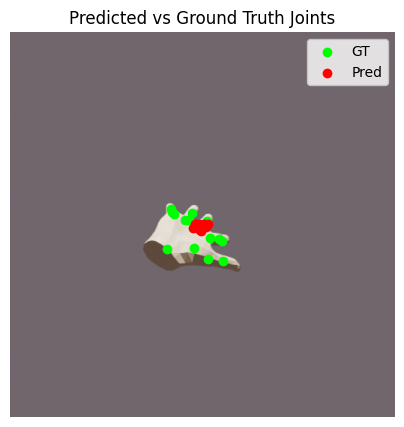

In [73]:
import matplotlib.pyplot as plt

models[0].eval()

with torch.no_grad():
    img_tensor, gt = dataset[0]
    input_tensor = img_tensor.unsqueeze(0).to(device)  # add batch dim
    pred = models[0](input_tensor).cpu()[0].numpy()  # shape: (16, 2)

gt_pixels = gt.numpy() * 512
pred_pixels = pred * 512

plt.figure(figsize=(5, 5))
plt.imshow(img_tensor.permute(1, 2, 0))  # convert (C, H, W) → (H, W, C)
plt.scatter(gt_pixels[:, 0], gt_pixels[:, 1], c='lime', label='GT')
plt.scatter(pred_pixels[:, 0], pred_pixels[:, 1], c='red', label='Pred')
plt.legend()
plt.title("Predicted vs Ground Truth Joints")
plt.axis('off')
plt.show()

# save the model

In [74]:
save_path = "checkpoints/hand_joint_model.pth"
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to checkpoints/hand_joint_model.pth


# compare with mediapipe


In [75]:
from PIL import Image
from torchvision import transforms


def predict_with_my_model(image_path, model, image_size=(256, 256), device="cpu"):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)[0].cpu().numpy()  # (16, 2)

    return output * 512, image  # Denormalize and return

In [76]:
import mediapipe as mp
import cv2


def predict_with_mediapipe(image_path):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image_rgb)
    landmarks = []

    if results.multi_hand_landmarks:
        for lm in results.multi_hand_landmarks[0].landmark[:16]:  # only first 16 joints
            landmarks.append([lm.x * 512, lm.y * 512])

    hands.close()
    return np.array(landmarks), Image.fromarray(image_rgb)

I0000 00:00:1754027404.924252 33818654 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1754027404.948951 37046269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754027404.955781 37046269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


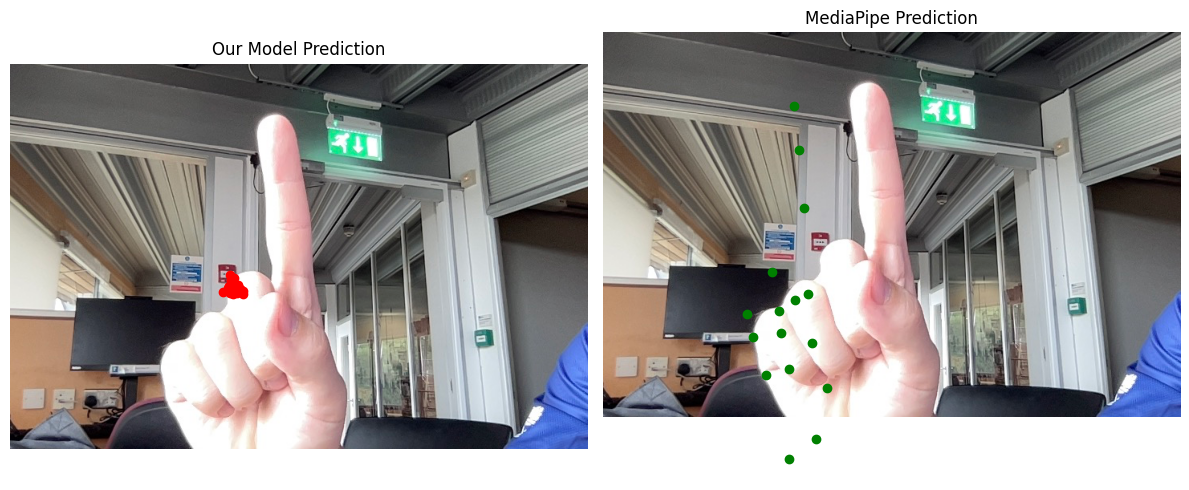

In [77]:
import matplotlib.pyplot as plt


def compare_predictions(img_path, model, device="cpu"):
    pred_ours, img = predict_with_my_model(img_path, model, device=device)
    pred_mp, _ = predict_with_mediapipe(img_path)

    plt.figure(figsize=(12, 6))

    # Ours
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.scatter(pred_ours[:, 0], pred_ours[:, 1], c='red')
    plt.title("Our Model Prediction")
    plt.axis('off')

    # MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    if len(pred_mp) == 16:
        plt.scatter(pred_mp[:, 0], pred_mp[:, 1], c='green')
        plt.title("MediaPipe Prediction")
    else:
        plt.title("MediaPipe Prediction (Not Detected)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


compare_predictions('../../../docs/gesture_design/img.png', model, device)

I0000 00:00:1754027405.403033 33818654 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M2
W0000 00:00:1754027405.412953 37046293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754027405.418760 37046293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


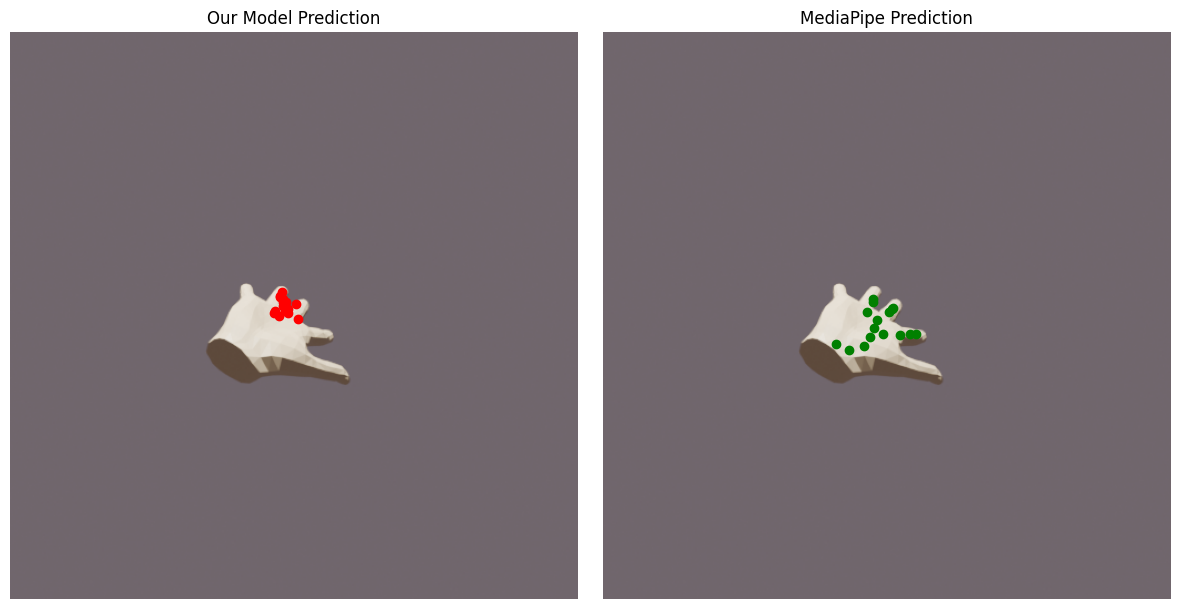

In [78]:
compare_predictions('../../../scripts/auto_generator/ply2obj2img/01_01r.png', model, device)